# Explore here

In [3]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
import joblib

# Load dataset
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
sales = pd.read_csv(url, parse_dates=['date'], index_col='date')
sales = sales.asfreq('MS')  # Set frequency to Month Start

print("Dataset head:")
print(sales.head())

# Check data length and fix if needed
print(f"\nOriginal data length: {len(sales)}")

# If data is too short for decomposition, use a shorter period
period = 6 if len(sales) < 24 else 12

Dataset head:
                                 sales
date                                  
2022-10-01 17:10:08.079328  127.475050
2022-11-01 17:10:08.079328  202.473420
2022-12-01 17:10:08.079328  284.807191
2023-01-01 17:10:08.079328  363.458044
2023-02-01 17:10:08.079328  448.153727

Original data length: 12


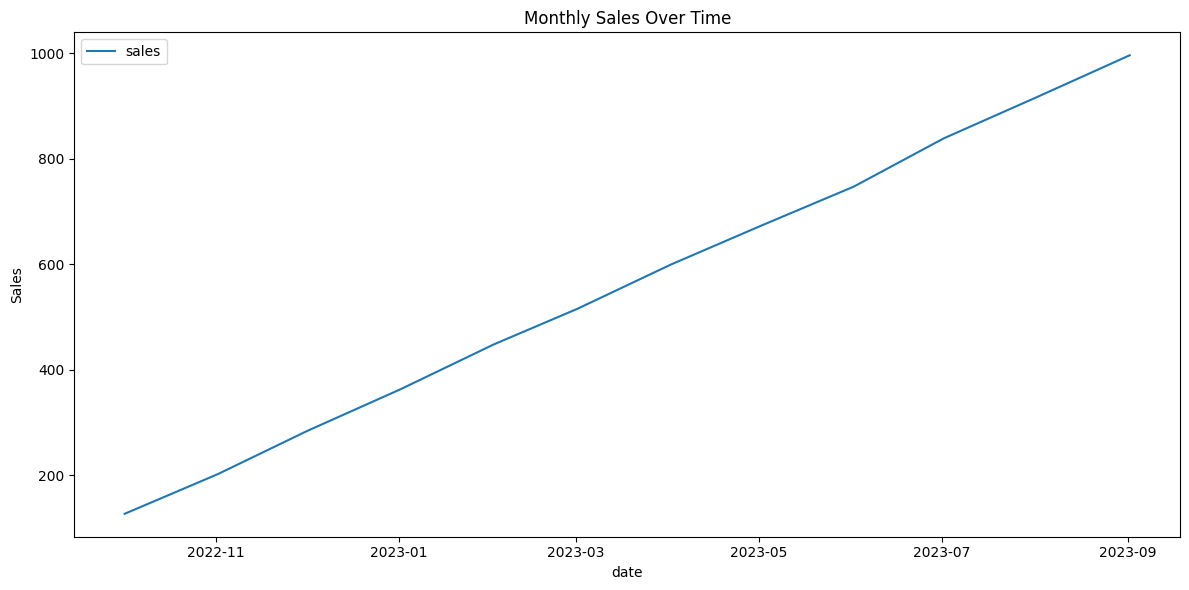


Time Series Analysis:
Tensor (frequency): MS
Date Range: 2022-10-01 17:10:08.079328 to 2023-09-01 17:10:08.079328
Missing Values: 0


ValueError: x must have 2 complete cycles requires 24 observations. x only has 12 observation(s)

In [4]:
# Plot the time series
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales)
plt.title('Monthly Sales Over Time')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# Time series analysis
print("\n" + "="*50)
print("Time Series Analysis:")
print(f"Tensor (frequency): {sales.index.freqstr}")
print(f"Date Range: {sales.index.min()} to {sales.index.max()}")
print(f"Missing Values: {sales.isnull().sum().values[0]}")

# Decompose the series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sales, period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

# Stationarity test
def test_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")
    return result[1] > 0.05

print("\nStationarity Check:")
is_non_stationary = test_stationarity(sales['sales'])
print(f"Series is {'non-stationary' if is_non_stationary else 'stationary'}")

# Variability analysis
rolling_window = min(6, len(sales) // 2)
rolling_std = sales.rolling(window=rolling_window).std()
plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_std)
plt.title('12-Month Rolling Standard Deviation')
plt.ylabel('Standard Deviation')
plt.tight_layout()
plt.show()

In [ ]:
# Split data (last 12 months for testing)
train = sales.iloc[:-12]
test = sales.iloc[-12:]
use_seasonal = len(train) > 24
# Find best ARIMA parameters
model = auto_arima(
    train,
    seasonal=use_seasonal,
    m=period if use_seasonal else 0,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print(model.summary())

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
# Generate predictions
forecast = model.predict(n_periods=12)
forecast = pd.Series(forecast, index=test.index)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Sales', color='blue')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.fill_between(forecast.index, 
                 forecast * 0.95, 
                 forecast * 1.05, 
                 color='red', alpha=0.1)
plt.title('Sales Forecast vs Actuals')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate metrics
mae = mean_absolute_error(test, forecast)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Error Percentage: {mae/test.mean().values[0]*100:.2f}%")

NameError: name 'model' is not defined

# joblib.dump(model, 'arima_sales_forecast_model.pkl')
# print("Model saved successfully!")